## Correción ADAM

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Funciones de pérdida

In [2]:
def grad_quadratic(theta, f_params):
    '''
    Gradiente de la funcion de costo 
           sum_i (theta@x[i]-y[i])**2
    '''
    
    X = f_params['X']
    y = f_params['y']

    err=theta[0]*X+theta[1]-y
    partial0=err
    partial1=X*partial0
    gradient= np.concatenate((partial1, partial0), axis=1)

    return np.sum(gradient, axis=0)*(1/X.shape[0])

def grad_exp(theta, f_params):
    '''
    Gradiente de la funcion de costo 
           sum_i 1-exp(-k(theta@x[i]-y[i])**2)
    '''
    
    kappa= f_params['kappa']
    X    = f_params['X']
    y    = f_params['y']
    err=theta[0]*X+theta[1]-y
    partial0=err*np.exp(-kappa*err**2)
    partial1=X*partial0
    gradient= np.concatenate((partial1, partial0), axis=1)
    
    return np.mean(gradient, axis=0)

El error se encuentra en las siguientes lineas:

```python
p = p/(1.-eta1_t)
v = v/(1.-eta2_t)
```

Ya que no se deben volver a actualizar las variables **p** y **q**, sino guardar el resultado en otras variables. Esto es:

```python
p_h = p/(1.-eta1_t)
v_h = v/(1.-eta2_t)
```

Y con estas nuevas variables realizar el paso de gradiente:

```python
theta = theta - alpha * p_h / (np.sqrt(v_h)+epsilon)
```

In [3]:
def ADAM(theta=[], grad=None, gd_params={}, f_params={}):
    '''
    Descenso de Gradiente Adaptable con Momentum(A DAM) 
    
    Parámetros
    -----------
    theta     :   condicion inicial
    grad      :   funcion que calcula el gradiente
    gd_params :   lista de parametros para el algoritmo de descenso, 
                      nIter    = gd_params['nIter'] número de iteraciones
                      alphaADA = gd_params['alphaADAM'] tamaño de paso alpha
                      eta1     = gd_params['eta1'] factor de momentum para la direccion 
                                 de descenso (0,1)
                      eta2     = gd_params['eta2'] factor de momentum para la el 
                                 tamaño de paso (0,1)
    f_params  :   lista de parametros para la funcion objetivo, 
                      kappa = f_params['kappa'] parametro de escala (rechazo de outliers)
                      X     = f_params['X'] Variable independiente
                      y     = f_params['y'] Variable dependiente                   

    Regresa
    -----------
    Theta     :   trayectoria de los parametros
                     Theta[-1] es el valor alcanzado en la ultima iteracion
    '''
    
    epsilon= 1e-8
    nIter    = gd_params['nIter']
    alpha    = gd_params['alphaADAM'] 
    eta1     = gd_params['eta1']
    eta2     = gd_params['eta2']
    p        = np.zeros(theta.shape)
    v        = 0.0
    Theta    = []
    eta1_t = eta1
    eta2_t = eta2
    
    for t in range(nIter):
        g  = grad(theta, f_params=f_params)
        p  = eta1*p + (1.0-eta1)*g
        v  = eta2*v + (1.0-eta2)*(g**2)
        p_h = p/(1.-eta1_t)
        v_h = v/(1.-eta2_t)
        theta = theta - alpha * p_h / (np.sqrt(v_h)+epsilon)
        eta1_t *= eta1
        eta2_t *= eta2
        Theta.append(theta)
        
    return np.array(Theta)

### Pruebas ADAM corregido

In [4]:
from sklearn import linear_model, datasets

# condición inicial

theta=10*np.random.normal(size=2)

n_samples = 500
X, y = datasets.make_regression(n_samples=n_samples,
                                n_features=1,
                                n_informative=2, 
                                noise=5,
                                random_state=0) #2)
n_outliers = 100
X[:n_outliers], y[:n_outliers] = datasets.make_regression(n_samples=n_outliers,
                                n_features=1,
                                n_informative=2, 
                                noise=2,
                                random_state=61)
y = np.expand_dims(y,axis=1)

In [5]:
# parámetros del algoritmo
gd_params = {'alpha'          : 0.95, 
             'alphaADADELTA'  : 0.7,
             'alphaADAM'      : 0.95,
             'nIter'          : 300,
             'batch_size'     : 100,
             'eta'            : 0.9,
             'eta1'           : 0.9,
             'eta2'           : 0.999}

# parámetros de la función objetivo
f_params={'kappa' : 0.01, 
          'X'     : X , 
          'y'     : y}


### Entrenamiento

In [6]:
ThetaADAM = ADAM(theta ,grad_exp, gd_params, f_params)

### Resultados

In [7]:
theta_h = ThetaADAM[-1]

In [8]:
x_line = np.arange(np.min(X), np.max(X), 0.1)
y_line = theta_h[0] * x_line + theta_h[1]

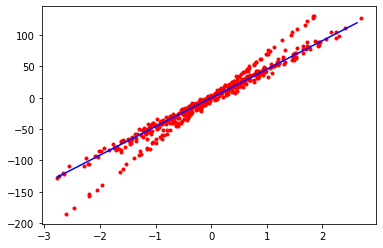

In [9]:
plt.scatter(X[:],y[:], marker='.', color = 'r')
plt.plot(x_line, y_line, '-', color = 'b')
plt.show()

### Comparación

In [10]:
def GD(theta=[], grad=None, gd_params={}, f_params={}):
    
    nIter = gd_params['nIter'] 
    alpha = gd_params['alpha']
    Theta=[]
    for t in range(nIter):
        p = grad(theta,f_params=f_params)
        theta = theta - alpha*p
        Theta.append(theta)
    return np.array(Theta)

def SGD(theta=[], grad=None, gd_params=[], f_params=[]):

    (high,dim) = f_params['X'].shape
    batch_size = gd_params['batch_size']
    
    nIter      = gd_params['nIter']
    alpha      = gd_params['alpha']
        
    Theta=[]
    for t in range(nIter):
        # Set of sampled indices
        smpIdx = np.random.randint(low=0, high=high, size=batch_size, dtype='int32')
        # sample 
        smpX = f_params['X'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'kappa' : f_params['kappa'], 
                      'X'     : smpX , 
                      'y'     : smpy}
        
        p = grad(theta,f_params=smpf_params)
        theta = theta - alpha*p
        Theta.append(theta)
        
    return np.array(Theta)

def MGD(theta=[], grad=None, gd_params={}, f_params={}):

    nIter = gd_params['nIter']
    alpha = gd_params['alpha'] 
    eta   = gd_params['eta']
    p_old = np.zeros(theta.shape)
    Theta=[]
    for t in range(nIter):
        g = grad(theta, f_params=f_params)
        p = g + eta*p_old
        theta = theta - alpha*p
        p_old=p
        Theta.append(theta)
    return np.array(Theta)

def NAG(theta=[], grad=None, gd_params={}, f_params={}):

    nIter = gd_params['nIter']
    alpha = gd_params['alpha'] 
    eta   = gd_params['eta']
    p     = np.zeros(theta.shape)
    Theta=[]
    
    for t in range(nIter):
        pre_theta = theta - 2.0*alpha*p
        g = grad(pre_theta, f_params=f_params)
        p = g + eta*p
        theta = theta - alpha*p
        Theta.append(theta)
    return np.array(Theta)

def ADADELTA(theta=[], grad=None, gd_params={}, f_params={}):

    epsilon= 1e-8
    nIter    = gd_params['nIter']
    alpha    = gd_params['alphaADADELTA'] 
    eta      = gd_params['eta']
    G        = np.zeros(theta.shape)
    g        = np.zeros(theta.shape) 
    Theta=[]
    for t in range(nIter):
        g = grad(theta, f_params=f_params)
        G = eta*g**2 + (1-eta)*G
        p = 1.0/(np.sqrt(G)+epsilon)*g
        theta = theta - alpha * p
        Theta.append(theta)
    return np.array(Theta)

In [11]:
ThetaGD = GD(theta=theta, grad=grad_exp, 
             gd_params=gd_params, f_params=f_params)

ThetaSGD = SGD(theta=theta, grad=grad_exp, 
               gd_params=gd_params, f_params=f_params)

ThetaMGD = MGD(theta=theta, grad=grad_exp, 
               gd_params=gd_params, f_params=f_params)

ThetaNAG = NAG(theta=theta, grad=grad_exp, 
               gd_params=gd_params, f_params=f_params)

ThetaADADELTA = ADADELTA(theta=theta, grad=grad_exp, 
                         gd_params=gd_params, f_params=f_params)

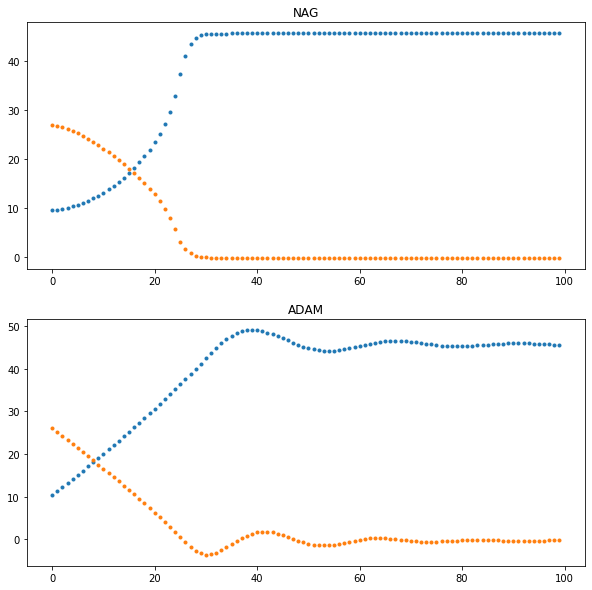

In [12]:
Tmax=100
plt.figure(figsize=(10,10))

plt.subplot(211)
plt.plot(ThetaNAG[:Tmax], '.')
plt.title('NAG')

plt.subplot(212)
plt.plot(ThetaADAM[:Tmax], '.')
plt.title('ADAM')

plt.show()

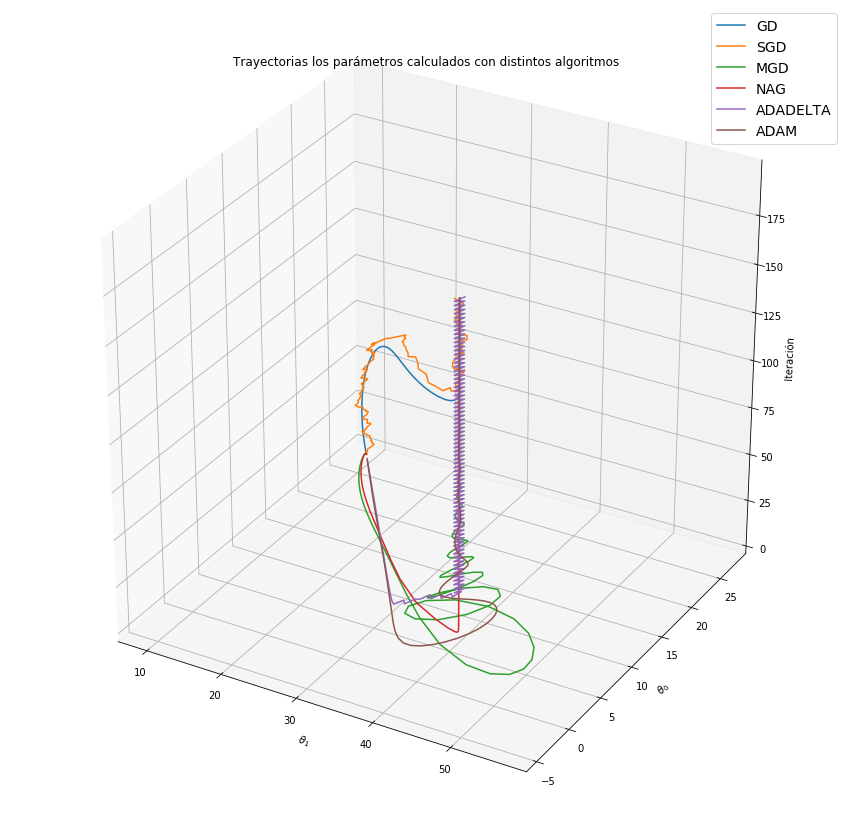

In [13]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 14

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
nIter=np.expand_dims(np.arange(ThetaGD.shape[0]),1) 
Tmax=200
ax.plot(ThetaGD[:Tmax,0],  ThetaGD [:Tmax,1], nIter[:Tmax,0], label='GD')
ax.plot(ThetaSGD[:Tmax,0], ThetaSGD[:Tmax,1], nIter[:Tmax,0], label='SGD')
ax.plot(ThetaMGD[:Tmax,0], ThetaMGD[:Tmax,1], nIter[:Tmax,0], label='MGD')
ax.plot(ThetaNAG[:Tmax,0], ThetaNAG[:Tmax,1], nIter[:Tmax,0], label='NAG')
ax.plot(ThetaADADELTA[:Tmax,0], ThetaADADELTA[:Tmax,1], nIter[:Tmax,0], label='ADADELTA')
ax.plot(ThetaADAM[:Tmax,0], ThetaADAM[:Tmax,1], nIter[:Tmax,0], label='ADAM')
ax.legend()
ax.set_title(r'Trayectorias los parámetros calculados con distintos algoritmos')
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_0$')
ax.set_zlabel('Iteración')
plt.show()

## Versión estocástica algoritmos

In [14]:
def MGD_s(theta=[], grad=None, gd_params={}, f_params={}):
    
    high, dim = f_params['X'].shape
    batch_size = gd_params['batch_size']
    nIter = gd_params['nIter']
    alpha = gd_params['alpha'] 
    eta   = gd_params['eta']
    p_old = np.zeros(theta.shape)
    
    Theta=[]
    
    for t in range(nIter):
        # Set of sampled indices
        smpIdx = np.random.randint(low=0, high=high, size=batch_size, dtype='int32')
        # sample 
        smpX = f_params['X'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'kappa' : f_params['kappa'], 
                      'X'     : smpX , 
                      'y'     : smpy}
        
        g = grad(theta, f_params=smpf_params)
        p = g + eta*p_old
        theta = theta - alpha*p
        p_old=p
        Theta.append(theta)
        
    return np.array(Theta)

def NAG_s(theta=[], grad=None, gd_params={}, f_params={}):
    
    high, dim = f_params['X'].shape
    batch_size = gd_params['batch_size']
    nIter = gd_params['nIter']
    alpha = gd_params['alpha'] 
    eta   = gd_params['eta']
    p     = np.zeros(theta.shape)
    
    Theta=[]
    
    for t in range(nIter):
        # Set of sampled indices
        smpIdx = np.random.randint(low=0, high=high, size=batch_size, dtype='int32')
        # sample 
        smpX = f_params['X'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'kappa' : f_params['kappa'], 
                      'X'     : smpX , 
                      'y'     : smpy}
        
        pre_theta = theta - 2.0*alpha*p
        g = grad(pre_theta, f_params=smpf_params)
        p = g + eta*p
        theta = theta - alpha*p
        Theta.append(theta)
        
    return np.array(Theta)

def ADADELTA_s(theta=[], grad=None, gd_params={}, f_params={}):
    
    high, dim = f_params['X'].shape
    batch_size = gd_params['batch_size']
    epsilon= 1e-8
    nIter    = gd_params['nIter']
    alpha    = gd_params['alphaADADELTA'] 
    eta      = gd_params['eta']
    G        = np.zeros(theta.shape)
    g        = np.zeros(theta.shape)
    
    Theta=[]
    
    for t in range(nIter):
        # Set of sampled indices
        smpIdx = np.random.randint(low=0, high=high, size=batch_size, dtype='int32')
        # sample 
        smpX = f_params['X'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'kappa' : f_params['kappa'], 
                      'X'     : smpX , 
                      'y'     : smpy}
        
        g = grad(theta, f_params=smpf_params)
        G = eta*g**2 + (1-eta)*G
        p = 1.0/(np.sqrt(G)+epsilon)*g
        theta = theta - alpha * p
        Theta.append(theta)
    
    return np.array(Theta)

def ADAM_s(theta=[], grad=None, gd_params={}, f_params={}):
    
    high, dim = f_params['X'].shape
    batch_size = gd_params['batch_size']
    epsilon= 1e-8
    nIter    = gd_params['nIter']
    alpha    = gd_params['alphaADAM'] 
    eta1     = gd_params['eta1']
    eta2     = gd_params['eta2']
    p        = np.zeros(theta.shape)
    v        = 0.0
    
    Theta    = []
    eta1_t = eta1
    eta2_t = eta2

    for t in range(nIter):
        # Set of sampled indices
        smpIdx = np.random.randint(low=0, high=high, size=batch_size, dtype='int32')
        # sample 
        smpX = f_params['X'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'kappa' : f_params['kappa'], 
                      'X'     : smpX , 
                      'y'     : smpy}
        
        g  = grad(theta, f_params=smpf_params)
        p  = eta1*p + (1.0-eta1)*g
        v  = eta2*v + (1.0-eta2)*(g**2)
        p_h = p/(1.-eta1_t)
        v_h = v/(1.-eta2_t)
        theta = theta - alpha * p_h / (np.sqrt(v_h)+epsilon)
        eta1_t *= eta1
        eta2_t *= eta2
        Theta.append(theta)
        
    return np.array(Theta)

In [15]:
ThetaSGD = SGD(theta=theta, grad=grad_exp, 
               gd_params=gd_params, f_params=f_params)

ThetaMGD = MGD_s(theta=theta, grad=grad_exp, 
               gd_params=gd_params, f_params=f_params)

ThetaNAG = NAG_s(theta=theta, grad=grad_exp, 
               gd_params=gd_params, f_params=f_params)

ThetaADADELTA = ADADELTA_s(theta=theta, grad=grad_exp, 
                         gd_params=gd_params, f_params=f_params)

ThetaADAM = ADAM_s(theta=theta, grad=grad_exp, 
                         gd_params=gd_params, f_params=f_params)

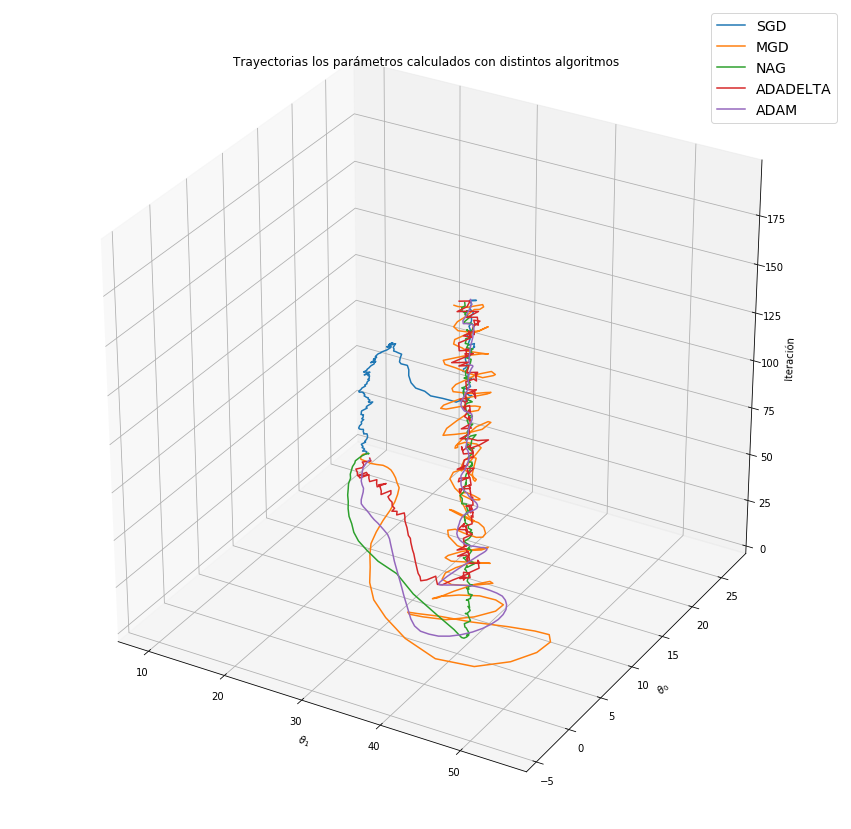

In [16]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 14

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
nIter=np.expand_dims(np.arange(ThetaGD.shape[0]),1) 
Tmax=200
ax.plot(ThetaSGD[:Tmax,0], ThetaSGD[:Tmax,1], nIter[:Tmax,0], label='SGD')
ax.plot(ThetaMGD[:Tmax,0], ThetaMGD[:Tmax,1], nIter[:Tmax,0], label='MGD')
ax.plot(ThetaNAG[:Tmax,0], ThetaNAG[:Tmax,1], nIter[:Tmax,0], label='NAG')
ax.plot(ThetaADADELTA[:Tmax,0], ThetaADADELTA[:Tmax,1], nIter[:Tmax,0], label='ADADELTA')
ax.plot(ThetaADAM[:Tmax,0], ThetaADAM[:Tmax,1], nIter[:Tmax,0], label='ADAM')
ax.legend()
ax.set_title(r'Trayectorias los parámetros calculados con distintos algoritmos')
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_0$')
ax.set_zlabel('Iteración')
plt.show()

## Radial Basis Functions

Se define la función de base radial con sus parámetros, $\mu$ y $\sigma$

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def rbf_gaussian(i, m, sigma):
    
    r, th = (i-m), 1./(2.*sigma)
    return np.exp(-(th*r)**2)

Función para construir la matriz de datos $\Phi$ de dimensión $nxp$ usada para encontrar el vector $\beta$ óptimo de dimensión $p$

In [18]:
def build_design_matrix(y, mu, sigma, basis_size):
    
    phi = []

    for y_i in y:

        phi_i = np.array([rbf_gaussian(y_i, m=mu[i], sigma=sigma) for i in range(basis_size)]).reshape((1, basis_size))

        phi.append(phi_i)

    return np.concatenate(phi)

Función que regresa el gradiente de la función de costo respecto al vector de parámetros $\mu$

In [19]:
def grad_rbf(theta, f_params):

    y = f_params['y']
    Phi = f_params['Phi']
    beta = f_params['beta']
    sigma = f_params['sigma']

    e = (Phi@beta-y).reshape((y.shape[0], 1))
    y = y.reshape((y.shape[0], 1))
    beta = beta.reshape((beta.shape[0], 1))
    
    prod1 = (y*np.ones((1,beta.shape[0])) - (np.ones((y.shape[0],1))*theta.T))
    prod2 = ((e*beta.T)*Phi)*prod1
    
    return np.mean(prod2, axis = 0)

Función para obtener la solución por ridge regression

In [20]:
def SolveRidgeRegression(X, y, tau):

    xtranspose = np.transpose(X)
    xtransx = np.dot(xtranspose, X)
    lamidentity = np.identity(xtransx.shape[0]) * tau
    matinv = np.linalg.inv(xtransx + lamidentity)
    xtransy = np.dot(xtranspose, y)
    beta = np.dot(matinv, xtransy)

    return beta

Algoritmos de gradiente descendiente estocásticos

In [21]:
def SGD_rbf(theta=[], grad=None, gd_params={}, f_params={}):
    
    high, dim = f_params['Phi'].shape
    batch_size = gd_params['batch_size']
    nIter    = gd_params['nIter']
    alpha    = gd_params['alpha']

    p_old = np.zeros(theta.shape)
    
    Theta    = []

    for t in range(nIter):
        
        # Set of sampled indices
        smpIdx = np.random.randint(low=0, high=high, size=batch_size, dtype='int32')
        # sample 
        smpPhi = f_params['Phi'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'Phi'     : smpPhi, 
                      'y'     : smpy,
                      'beta' : f_params['beta'],
                      'sigma' : f_params['sigma'],
                      'batch_size' : batch_size}

        p = grad(theta, f_params=smpf_params)
        theta = theta - alpha*p
                
        Theta.append(theta)
        
    return np.array(Theta)

def MGD_s_rbf(theta=[], grad=None, gd_params={}, f_params={}):
    
    high, dim = f_params['Phi'].shape
    batch_size = gd_params['batch_size']
    nIter    = gd_params['nIter']
    alpha    = gd_params['alpha'] 
    eta   = gd_params['eta']

    p_old = np.zeros(theta.shape)
    
    Theta    = []

    for t in range(nIter):
        
        # Set of sampled indices
        smpIdx = np.random.randint(low=0, high=high, size=batch_size, dtype='int32')
        # sample 
        smpPhi = f_params['Phi'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'Phi'     : smpPhi, 
                      'y'     : smpy,
                      'beta' : f_params['beta'],
                      'sigma' : f_params['sigma'],
                      'batch_size' : batch_size}

        g = grad(theta, f_params=smpf_params)
        p = g + eta*p_old
        theta = theta - alpha*p
        p_old = p
                
        Theta.append(theta)
        
    return np.array(Theta)

def NAG_s(theta=[], grad=None, gd_params={}, f_params={}):
    
    high, dim = f_params['Phi'].shape
    batch_size = gd_params['batch_size']
    nIter = gd_params['nIter']
    alpha = gd_params['alpha'] 
    eta   = gd_params['eta']
    p     = np.zeros(theta.shape)
    
    Theta=[]
    
    for t in range(nIter):
        # Set of sampled indices
        smpIdx = np.random.randint(low=0, high=high, size=batch_size, dtype='int32')
        # sample 
        smpPhi = f_params['Phi'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'Phi'     : smpPhi, 
                      'y'     : smpy,
                      'beta' : f_params['beta'],
                      'sigma' : f_params['sigma'],
                      'batch_size' : batch_size}
        
        pre_theta = theta - 2.0*alpha*p
        g = grad(pre_theta, f_params=smpf_params)
        p = g + eta*p
        theta = theta - alpha*p
        Theta.append(theta)
        
    return np.array(Theta)

def ADAGRAD_s(theta=[], grad=None, gd_params={}, f_params={}):
    
    high, dim = f_params['Phi'].shape
    batch_size = gd_params['batch_size']
    epsilon= 1e-8
    nIter    = gd_params['nIter']
    alpha    = gd_params['alphaADADELTA'] 
    eta      = gd_params['eta']
    G        = np.zeros(theta.shape)
    g        = np.zeros(theta.shape)
    
    Theta=[]
    
    for t in range(nIter):
        # Set of sampled indices
        smpIdx = np.random.randint(low=0, high=high, size=batch_size, dtype='int32')
        # sample 
        smpPhi = f_params['Phi'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'Phi'     : smpPhi, 
                      'y'     : smpy,
                      'beta' : f_params['beta'],
                      'sigma' : f_params['sigma'],
                      'batch_size' : batch_size}
        
        g = grad(theta, f_params=smpf_params)
        G += g**2
        p = 1.0/(np.sqrt(G)+epsilon)*g
        theta = theta - alpha * p
        Theta.append(theta)
    
    return np.array(Theta)

def ADADELTA_s(theta=[], grad=None, gd_params={}, f_params={}):
    
    high, dim = f_params['Phi'].shape
    batch_size = gd_params['batch_size']
    epsilon= 1e-8
    nIter    = gd_params['nIter']
    alpha    = gd_params['alphaADADELTA'] 
    eta      = gd_params['eta']
    G        = np.zeros(theta.shape)
    g        = np.zeros(theta.shape)
    
    Theta=[]
    
    for t in range(nIter):
        # Set of sampled indices
        smpIdx = np.random.randint(low=0, high=high, size=batch_size, dtype='int32')
        # sample 
        smpPhi = f_params['Phi'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'Phi'     : smpPhi, 
                      'y'     : smpy,
                      'beta' : f_params['beta'],
                      'sigma' : f_params['sigma'],
                      'batch_size' : batch_size}
        
        g = grad(theta, f_params=smpf_params)
        G = eta*g**2 + (1-eta)*G
        p = 1.0/(np.sqrt(G)+epsilon)*g
        theta = theta - alpha * p
        Theta.append(theta)
    
    return np.array(Theta)

def ADAM_s_rbf(theta=[], grad=None, gd_params={}, f_params={}):
    
    high, dim = f_params['Phi'].shape
    batch_size = gd_params['batch_size']
    epsilon= 1e-8
    nIter    = gd_params['nIter']
    alpha    = gd_params['alphaADAM'] 
    eta1     = gd_params['eta1']
    eta2     = gd_params['eta2']
    p        = np.zeros(theta.shape)
    v        = 0.0
    
    Theta    = []
    
    eta1_t = eta1
    eta2_t = eta2

    for t in range(nIter):
        
        # Set of sampled indices
        smpIdx = np.random.randint(low=0, high=high, size=batch_size, dtype='int32')
        # sample 
        smpPhi = f_params['Phi'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'Phi'     : smpPhi, 
                      'y'     : smpy,
                      'beta' : f_params['beta'],
                      'sigma' : f_params['sigma'],
                      'batch_size' : batch_size}
        
        g  = grad(theta, f_params=smpf_params)
        p  = eta1*p + (1.0-eta1)*g
        v  = eta2*v + (1.0-eta2)*(g**2)
        p_h = p/(1.-eta1_t)
        v_h = v/(1.-eta2_t)
        theta = theta - alpha * p_h / (np.sqrt(v_h)+epsilon)
        eta1_t *= eta1
        eta2_t *= eta2
                
        Theta.append(theta)
        
    return np.array(Theta)

Función de entrenamiento

In [22]:
def train(gd_params, f_params, iters, gradient_method, tau):
    
    for i in range(iters):
    
        mu_old = f_params['mu'][:]
        f_params['Phi'] = build_design_matrix(f_params['y'], f_params['mu'], f_params['sigma'], f_params['basis_size'])
        #f_params['beta'] = np.linalg.lstsq(f_params['Phi'], f_params['y'], rcond=None)[0].reshape((f_params['basis_size'], 1))
        f_params['beta'] = SolveRidgeRegression(f_params['Phi'], f_params['y'], tau).reshape((f_params['basis_size'], 1))
        mu = gradient_method(theta=f_params['mu'], grad=grad_rbf, 
                             gd_params=gd_params, f_params=f_params)
        f_params['mu'] = mu[-1]

        #print("\nCurrent iter: {0}".format(i+1))

        if np.linalg.norm(mu_old-f_params['mu']) < f_params['epsilon']:

            print("Stop at iteration {0}".format(i+1))
            break;

Entrenamiento y resultados


Imagen usada:


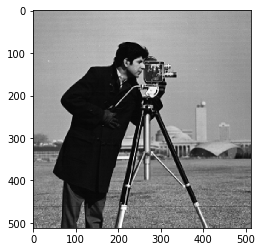

Start training: 
_____________________________________________________________

Entrenando método estocastico
Stop at iteration 1

MSE estocastico : 0.2890512616527156


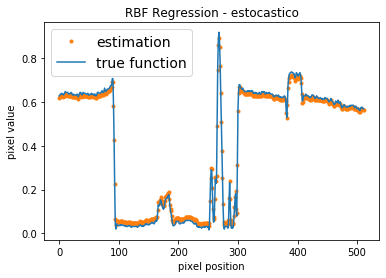

_____________________________________________________________

Entrenando método momentum
Stop at iteration 1

MSE momentum : 0.17964929226748658


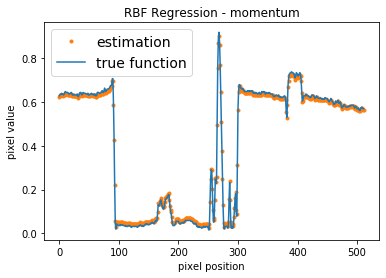

_____________________________________________________________

Entrenando método nesterov
Stop at iteration 1

MSE nesterov : 0.14657986711542356


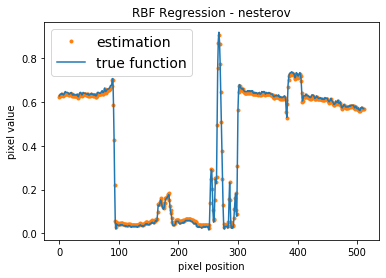

_____________________________________________________________

Entrenando método ADAGRAD
Stop at iteration 2

MSE ADAGRAD : 0.15450150767969012


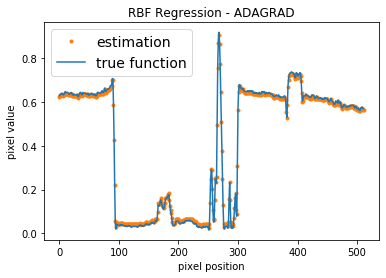

_____________________________________________________________

Entrenando método ADADELTA
Stop at iteration 6

MSE ADADELTA : 0.14053661969991632


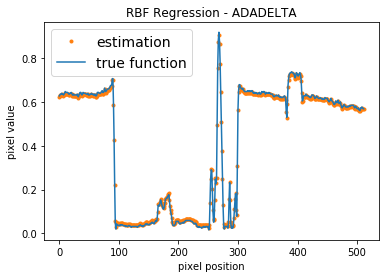

_____________________________________________________________

Entrenando método ADAM
Stop at iteration 45

MSE ADAM : 0.13219029351294112


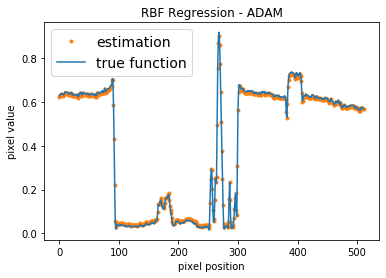

In [28]:
# Parámetros

from skimage import data, img_as_float

print("\nImagen usada:")
plt.imshow(img_as_float(data.camera()), interpolation='nearest')
plt.gray()
plt.show()
y = img_as_float(data.camera())[250,:]
y = y.reshape((y.shape[0], 1))

gd_params = {'alphaADAM'      : 0.01,
             'alphaADADELTA'      : 0.01,
             'alpha'          : 1e-4,
             'nIter'          : 10,
             'batch_size'     : 256,
             'eta'            : 0.9,
             'eta1'           : 0.9,
             'eta2'           : 0.999}

f_params = {'y'     : y, 
            'Phi'  : [],
            'beta' : []}

f_params['sigma'] = 10
f_params['tau'] = 0.01
f_params['basis_size'] = 10
f_params['epsilon'] = 0.1
f_params['mu'] = np.linspace(0, 255, f_params['basis_size'])

methods = {'estocastico' : SGD_rbf,
           'momentum' : MGD_s_rbf, 
           'nesterov' : NAG_s,
           'ADAGRAD' : ADAGRAD_s,
           'ADADELTA' : ADADELTA_s,
           'ADAM' : ADAM_s_rbf}

# Entrenamiento

print("Start training: ")

for grad_method in methods.keys():

    f_params['y'] = y
    f_params['mu'] = np.random.normal(np.mean(f_params['y']), f_params['sigma'], f_params['basis_size'])
    
    print("_____________________________________________________________")
    print("\nEntrenando método " + grad_method)
    
    train(gd_params, f_params, 100, methods[grad_method], f_params['tau'])

    # Resultados

    y_h = f_params['Phi'].dot(f_params['beta'])
    
    print("\nMSE " + grad_method + " : {}".format(np.linalg.norm(f_params['y']-y_h)))

    fig, ax = plt.subplots()
    ax.plot(y_h, '.', color = 'tab:orange')
    ax.plot(f_params['y'], color = 'tab:blue')
    ax.legend(['estimation', 'true function'])
    ax.set(xlabel = 'pixel position', ylabel = 'pixel value', title = 'RBF Regression - ' + grad_method)
    plt.show()

Como se pudo observar en la comparación de los métodos de gradiente descendendiente estocásticos el que tuvo mejor desempeño fue el algoritmo ADAM dando un error cuadrático de 0.13. Después de ADAM, los que tuvieron mejor desempeño fueron los algoritmos Nesterov, ADAGRAD y ADADELTA. El quinto lugar en desempeño lo obtuvo el algoritmo de Momento con un error cuadrático de 0.179. Finalmente, el algoritmo con peor desempeño fue el Estocástico, con un error cuadrático de 0.289.

La información se resume en la siguiente tabla ordenando los algoritmos de mejor a peor desempeño:

| Algoritmo | Error |
| --- | --- |
| ADAM | 0.132 |
| ADADELTA | 0.14 |
| Nesterov | 0.146 |
| ADAGRAD | 0.154 |
| Momentum | 0.179 |
| SGD | 0.289 |

#### Reconstruyendo imagen, renglón a renglón, para comprobar que el modelo se ajusta correctamente a los datos

In [24]:
image = img_as_float(data.camera())

imagen_estimada = []
num_rows = image.shape[0]

gd_params = {'alphaADAM'      : 0.01,
             'nIter'          : 40,
             'batch_size'     : 256,
             'eta'            : 0.9,
             'eta1'           : 0.9,
             'eta2'           : 0.999}

# parámetros de la función objetivo

f_params = {'y'     : y, 
            'Phi'  : [],
            'beta' : []}

f_params['sigma'] = 10
f_params['tau'] = 0.01
f_params['basis_size'] = 10
f_params['epsilon'] = 0.1
f_params['mu'] = np.random.normal(np.mean(f_params['y']), f_params['sigma'], f_params['basis_size'])

for j in range(num_rows):
    
    #print("Image row {}".format(j))
    
    f_params['y'] = image[j, :].reshape(image.shape[0], 1)
    
    for i in range(100):
    
        mu_old = f_params['mu'][:]
        f_params['Phi'] = build_design_matrix(f_params['y'], f_params['mu'], f_params['sigma'], f_params['basis_size'])
        f_params['beta'] = SolveRidgeRegression(f_params['Phi'], f_params['y'], f_params['tau']).reshape((f_params['basis_size'], 1))
        mu = ADAM_s_rbf(theta=f_params['mu'], grad=grad_rbf, 
                             gd_params=gd_params, f_params=f_params)
        f_params['mu'] = mu[-1]

        if np.linalg.norm(mu_old-f_params['mu']) < f_params['epsilon']:
            break;
            
    y_hat = f_params['Phi'].dot(f_params['beta'])
        
    imagen_estimada.append(y_hat)

#### Imagen reconstruida mediante RBF

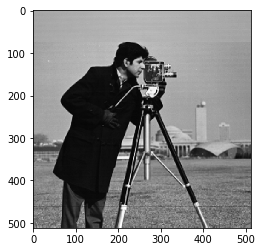

In [25]:
plt.imshow(np.array(imagen_estimada)[:,:,0], interpolation='nearest')
plt.gray()
plt.show()

#### Imagen original

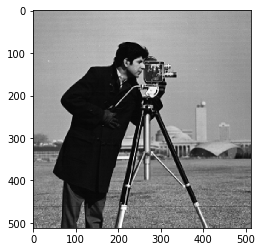

In [26]:
plt.imshow(image, interpolation='nearest')
plt.gray()
plt.show()